In [8]:
# coding: utf-8
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.mail import mail
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate,
                                                     BarGenerator,
                                                     ArrayManager)

from collections import defaultdict
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime


class FishStrategy(CtaTemplate):
    className = 'FishStrategy'
    author = 'YJJ'

    # 策略交易标的
    symbol = EMPTY_STRING  
    posDict = {}  # 仓位数据缓存
    eveningDict = {}  # 可平仓量数据缓存
    bondDict = {}  # 保证金数据缓存

    # 策略参数
    lmaPeriod = 31    #长线周期30
    smaPeriod = 3     #短线周期3
    cciPeriod = 16    #CCI周期16
    satrWindow = 9   #STR长周期10
    latrWindow = 19   #STR短周期20
    initDays = 1      #初始化天数
    stopRatio = 0.03  #止损比例
    initbars = 40
    MA = 0
    ATR = 0
    OBV = 0
    CCI = 0

    # 策略变量
    initbars = 100  # 获取历史数据的条数
    posSize= 1
    flag = 0
#     longStop = 0                        # 多头止损
#     shortStop = 0                       # 空头止损
    Trend = 0
    transactionPrice = EMPTY_FLOAT  # 记录成交价格
    fixedSize = 1
    longStop = EMPTY_FLOAT
    shortStop = EMPTY_FLOAT

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'lmaPeriod',
                 'smaPeriod',
                 'cciPeriod',
                 'satrWindow',
                 'latrWindow',
                 'initbars',
                 'fixedSize',
                 'stopRatio',
                 'initDays']

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'posSize',
                'longStop',
               'shortStop',
               'MA',
               'OBV',
               'ATR',
               'CCI'
               'transactionPrice',
               'fixedSize'
               ]

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'eveningDict',
                'bondDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(FishStrategy, self).__init__(ctaEngine, setting)
        self.symbolList = setting['symbolList']

        self.OBV = 0
        self.MA30 = 0
        self.MA5 = 0
        self.CCI = 0
        self.lag = 600
        self.stopLosslong = 0
        self.stopLossshort = 0
        self.ATR = 0



        ###########################
        self.intradeHigh = 0
        self.intradeLow = 0
        # ----------------------------------------------------------------------

    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：初始化' % self.className)
        self.symbol = self.symbolList[0]

        # 构造K线合成器对象
        self.bgDict = {
            sym: BarGenerator(self.onBar)
            for sym in self.symbolList
        }
        
        self.amDict = {
            sym: ArrayManager()
            for sym in self.symbolList
        }

        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }

        self.bg45 = BarGenerator(self.onBar, 45, self.on45MinBar)
        self.bg45Dict = {
            sym: self.bg45
            for sym in self.symbolList
        }

        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.lmaPeriod + 10)
            for sym in self.symbolList
        }

        self.am45Dict = {
            sym: ArrayManager(size=self.lmaPeriod + 10)
            for sym in self.symbolList
        }


        self.putEvent()
        '''
        在点击初始化策略时触发,载入历史数据,会推送到onbar去执行updatebar,但此时ctaEngine下单逻辑为False,不会触发下单.
        '''
#         pastbar15 = self.loadHistoryBar(self.symbol,'15min',1000)[:-80]
#         pastbar60 = self.loadHistoryBar(self.symbol,'60min',1000)[:-20]
#         pastbar1 = self.loadHistoryBar(self.symbol,'1min',1200)

#         for bar15 in pastbar15:
#             self.am15Dict[self.symbol].updateBar(bar15)

#         for bar60 in pastbar60:
#             self.am60Dict[self.symbol].updateBar(bar60)

#         for bar1 in pastbar1:
#             self.onBar(bar1)

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：启动' % self.className)
        # self.ctaEngine.loadSyncData(self)    # 加载当前正确的持仓
        self.putEvent()
        '''
        在点击启动策略时触发,此时的ctaEngine会将下单逻辑改为True,此时开始推送到onbar的数据会触发下单.
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
#         self.writeCtaLog(u'策略%s：停止' % self.className)
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """从错误状态恢复策略（必须由用户集成实现）"""
#         self.writeCtaLog(u'策略%s：恢复策略状态成功' % self.Name)
        self.putEvent()
    
    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        self.bgDict[tick.vtSymbol].updateTick(tick)
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到1分钟K线推送"""
        self.cancelAll()
        # 基于60分钟判断趋势过滤，因此先更新

        bg60 = self.bg60Dict[self.symbol]
        bg60.updateBar(bar)

        # 基于15分钟判断
        bg45 = self.bg45Dict[self.symbol]
        bg45.updateBar(bar)

#         # 洗价器
#         if (self.posDict[self.symbol+"_LONG"] > 0):
#             if (bar.close < self.transactionPrice * (1 - self.stopRatio)) or (
#                     bar.close > self.transactionPrice * (1 + 2 * self.stopRatio)):
#                 self.cancelAll()
#                 self.sell(self.symbol, bar.close*0.98, self.fixedSize, marketPrice="0")
# #                 self.writeCtaLog('平多仓 止盈或止损')
#         elif (self.posDict[self.symbol+"_SHORT"] > 0):
#             if (bar.close > self.transactionPrice * (1 + self.stopRatio)) or (
#                     bar.close < self.transactionPrice * (1 - 2 * self.stopRatio)):
#                 self.cancelAll()
#                 self.cover(self.symbol, bar.close*1.02 , self.fixedSize,marketPrice="0")
# #                 self.writeCtaLog('平空仓 止盈或止损')
        
        # 移动止损和固定止盈洗价器-2018年9月1日 17:12:22
        # if (self.posDict[self.symbol+"_LONG"] > 0):
        #     # 多头移动止损和固定止盈
        #     self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
        #     self.intraTradeLow = bar.low
        #     self.longStop = self.intraTradeHigh*(1-self.stopRatio)
        #     self.lone_exit = self.transactionPrice * (1 + 2 * self.stopRatio)
        #     self.writeCtaLog('多头止损价格:%s'%self.longStop)
        #     self.writeCtaLog('多头止盈价格:%s'%self.lone_exit)           
        #     if bar.close<=self.longStop:
        #         self.cancelAll()
        #         self.sell(self.symbol, bar.close*0.98, self.fixedSize)
        #     self.writeCtaLog('移动止损出场，出场价格为:%s' %self.transactionPrice)

        # elif self.posDict[self.symbol+"_SHORT"] >0:
        #     self.intraTradeLow = min(self.intraTradeLow, bar.low)
        #     self.intraTradeHigh = bar.high
        #     self.shortStop = self.intraTradeLow*(1+self.stopRatio)
        #     self.shortexit = self.transactionPrice * (1 - 2* self.stopRatio)
        #     self.writeCtaLog('空头止损价格:%s' % self.shortStop)
        #     self.writeCtaLog('空头止盈价格:%s' % self.shortexit)
        #     if bar.close>=self.shortStop:
        #         self.cancelAll()
        #         self.cover(self.symbol, bar.close*1.02, self.fixedSize)
        #     self.writeCtaLog('移动止损出场，出场价格为:%s' % self.transactionPrice)
            
        self.putEvent()

        # ----------------------------------------------------------------------
    def on60MinBar(self, bar):
            """60分钟K线推送"""

            am60 = self.am60Dict[self.symbol]
            am60.updateBar(bar)

            if not am60.inited:
                return

#             # 计算均线并判断趋势
#             fastMa = ta.MA(am60.close, self.fastWindow)
#             slowMa = ta.MA(am60.close, self.slowWindow)

#             if fastMa[-1] > slowMa[-1]:
#                 self.maTrend = 1
#             else:
#                 self.maTrend = -1
#                 #         print(fastMa)

#                 # if fastMa[-1] > slowMa[-1]:
#                 #   self.maTrend = 1
#                 # else:
#                 #   self.maTrend = -1

#                 # a=am60.Return(am60.close,1)
#                 # b=am60.Return(am60.close,5)
#                 # c=am60.Return(am60.close,10)
#                 # d=am60.Return(am60.close,15)
#             a = am60.close
#             if a[-1] > a[-5]:
#                 self.ab = 1
#             else:
#                 self.ab = -1
#             if a[-5] > a[-10]:
#                 self.bc = 1
#             else:
#                 self.bc = -1
#             if a[-10] > a[-15]:
#                 self.cd = 1
#             else:
#                 self.cd = -1
# #             self.writeCtaLog('signa a[-1]:%s, a[-5]:%s,a[-10]:%s,a[-15]:%s'%(a[-1],a[-5],a[-10],a[-15]))
#                 # if a[-15] > a[-20]:
#                 #   self.de = 1
#                 # else:
#                 #   self.de = -1

            # ----------------------------------------------------------------------
    def on45MinBar(self, bar):
            """收到Bar推送（必须由用户继承实现）"""
            self.cancelAll()

            am45 = self.am45Dict[self.symbol]
            am45.updateBar(bar)
            if not am45.inited:
                return

            
               # 洗价器------------------------------------------------------------------------------------
            if (self.posDict[self.symbol+"_LONG"] > 0):
                if (bar.close<self.transactionPrice*(1-self.stopRatio)):
                    self.sell(self.symbol,bar.close*0.98,self.fixedSize)
                    self.stopLosslong = 1
                    self.stopLong = bar.datetime
                elif (bar.close>self.transactionPrice*(1+1.25*self.stopRatio)):
                    self.sell(self.symbol,bar.close*0.98,self.fixedSize)
            
            elif (self.posDict[self.symbol+"_SHORT"] > 0):
                if (bar.close>self.transactionPrice*(1+self.stopRatio)):
                    self.stopLossshort = 1
                    self.cover(self.symbol,bar.close*1.02,self.fixedSize)
                    self.stopShort = bar.datetime
                elif (bar.close<self.transactionPrice*(1-1.25*self.stopRatio)):
                    self.cover(self.symbol,bar.close*1.02,self.fixedSize)
                
                # self.putEvent()
        
        
    #止损时间控制器       
    #--------------------------------------------------------------------------------------
                
        
        
            if self.stopLosslong != 0:
                long = (bar.datetime - self.stopLong).total_seconds()/60
            else:
                long = self.lag+1

            if self.stopLossshort != 0:
                short = (bar.datetime - self.stopShort).total_seconds()/60
            else:
                short = self.lag+1
            
            
    # 指标计算   
    #---------------------------------------------------------------------------
            
            
            obv = ta.OBV(am45.close,am45.volume)
            smaobv = ta.MA(obv,self.smaPeriod)
            lmaobv = ta.MA(obv,self.lmaPeriod)
            MA30 = ta.MA(am45.close,self.lmaPeriod)
            MA5 = ta.MA(am45.close,self.smaPeriod)
            cci = ta.CCI(am45.high, am45.low, am45.close, self.cciPeriod)
            sATR = ta.ATR(am45.high, am45.low, am45.close, self.satrWindow)
            lATR = ta.ATR(am45.high, am45.low, am45.close, self.latrWindow)
        
        # 波动率控制
            if sATR[-1]>=1.1*lATR[-1]:
                self.ATR = 1
            elif sATR[-1]<=0.9*lATR[-1]:
                self.ATR = -1
            else:
                self.ATR = 0
        
            
       
        
        
    # 买卖区间控制 
            if 70<=cci[-1]<=100:
                self.CCI = 1
            elif -100<=cci[-1]<=-70:
                self.CCI = -1
            else:
                self.CCI = 0
            
            
    # 动量信号，计算上涨下跌可能性大小
            if smaobv[-1]>=smaobv[-2] and smaobv[-1]>=lmaobv[-1]:#买入信号
                self.OBV = 1
            elif smaobv[-1]<=smaobv[-2] and smaobv[-1]<=lmaobv[-1]:#卖出信号
                self.OBV = -1
            else:
                self.OBV = 0
            
        
    # 均线控制，金叉，死叉，向上向下突破
            if MA5[-1]>=MA5[-2] and MA5[-1]>=MA30[-1]:#短线穿长线
                self.MA = 1
            elif MA5[-1]<=MA5[-2] and MA5[-1]<=MA30[-1]:
                self.MA = -1
            else:
                self.MA = 0
            
       
    # 信号组合   
            Signal = self.ATR + self.CCI + self.OBV + self.MA 
      
#             self.writeCtaLog('实时信号:MA:%s, OBV:%s, CCI:%s, ATR:%s'%(self.MA, self.OBV, self.CCI, self.ATR)) 
     
    # 进出场信号判断
            if Signal==4:
                if (self.posDict[self.symbol+"_LONG"]==0) and (self.posDict[self.symbol+"_SHORT"]==0) and long>self.lag:
                    self.buy(self.symbol,bar.close*1.1, self.fixedSize)
                elif self.posDict[self.symbol+"_SHORT"]>0:     
                    self.cancelAll()
                    self.cover(self.symbol,bar.close*1.02, self.posDict[self.symbol+"_SHORT"])
                    if long> self.lag:
                        self.buy(self.symbol,bar.close*1.02, self.fixedSize)
                 
                
            elif Signal==-4:
                if (self.posDict[self.symbol+"_LONG"]==0) and (self.posDict[self.symbol+"_SHORT"]==0) and short> self.lag:
                    self.short(self.symbol,bar.close*0.98, self.fixedSize)
                elif self.posDict[self.symbol+"_LONG"]>0:
                    self.cancelAll()
                    self.sell(self.symbol,bar.close*0.98, self.fixedSize)
                    if short> self.lag:
                        self.short(self.symbol,bar.close*0.98, self.fixedSize)
                  
                
      
            
                self.putEvent()
            



            # ----------------------------------------------------------------------



    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""

        self.putEvent()

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交信息变化推送"""
        #print("\n\n\n\n stg onTrade", trade.vtSymbol)
        self.transactionPrice = trade.price
        print('trade direction',trade.direction,'offset',trade.offset,'price',trade.price, trade.dt)

#         self.writeCtaLog('onTrade price:%s'%trade.price)
        # self.saveSyncData()
        pass

    # ---------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


# BTC binance数据

In [9]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20170701 01:01',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180909 01:01')
#     engine.setStartDate('20180508 01:01',initDays=1)               # 设置回测用的数据起始日期
#     engine.setEndDate('20180710 01:01')
    
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(100000)  # 设置回测本金


    # # 在引擎中创建策略对象
    d = {'symbolList':['BTCUSDT:binance']}          # 策略参数配置
    engine.initStrategy(FishStrategy, d)    # 创建策略对象
#     test = open('log.txt','w') 
    engine.runBacktesting()
#     test.close()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0} 
可平仓量: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-09-10 17:32:44.206347	开始回测
2018-09-10 17:32:44.206347	策略初始化
2018-09-10 17:32:44.206347	载入历史数据。数据范围:[20170630 01:01,20170701 01:01)
2018-09-10 17:32:44.246770	！！没有数据没有数据没有数据！！
2018-09-10 17:32:44.247269	策略初始化完成
2018-09-10 17:32:44.247269	策略启动完成
2018-09-10 17:32:44.247269	开始回放回测数据,回测范围:[20170701 01:01,20180909 01:01)
2018-09-10 17:32:44.334104	载入历史数据。数据范围:[20170701 01:01,20180909 01:01)
2018-09-10 17:45:11.580043	载入完成，数据量：358094
2018-09-10 17:45:11.630449	当前回放数据:[20170701 01:01,20180909 01:01)
trade direction 空 offset 开仓 price 14773.98 2018-01-09 18:01:00
trade direction 多 offset 平仓 price 14100.0 2018-01-09 22:01:00
trade direction 空 offset 开仓 price 13445.0 2018-01-12 06:01:00
trade direction 多 offset 平仓 price 12935.62 2018-01-12 07:01:00
trade direction 空 offset 开仓 price 13380.0 2018-01-13 03:01:00
trade direction 多 offset 平仓 price 13820.01 2018-01-

2018-09-10 17:45:19.607778	计算按日统计结果
2018-09-10 17:45:19.659180	------------------------------
2018-09-10 17:45:19.659180	首个交易日：	2018-01-01 00:00:00
2018-09-10 17:45:19.659180	最后交易日：	2018-09-09 00:00:00
2018-09-10 17:45:19.659679	总交易日：	252
2018-09-10 17:45:19.659679	盈利交易日	57
2018-09-10 17:45:19.659679	亏损交易日：	34
2018-09-10 17:45:19.659679	起始资金：	100000
2018-09-10 17:45:19.659679	结束资金：	832,358.39
2018-09-10 17:45:19.659679	总收益率：	732.36%
2018-09-10 17:45:19.659679	年化收益：	697.48%
2018-09-10 17:45:19.659679	总盈亏：	732,358.39
2018-09-10 17:45:19.659679	最大回撤: 	-114,434.65
2018-09-10 17:45:19.660178	百分比最大回撤: -21.04%
2018-09-10 17:45:19.660178	总手续费：	36,186.81
2018-09-10 17:45:19.660178	总滑点：	1.8
2018-09-10 17:45:19.660178	总成交金额：	72,373,627.0
2018-09-10 17:45:19.660178	总成交笔数：	90
2018-09-10 17:45:19.660178	日均盈亏：	2,906.18
2018-09-10 17:45:19.660178	日均手续费：	143.6
2018-09-10 17:45:19.660178	日均滑点：	0.01
2018-09-10 17:45:19.660677	日均成交金额：	287,196.93
2018-09-10 17:45:19.660677	日均成交笔数：	0.36
2018-09-10 17:45:19.

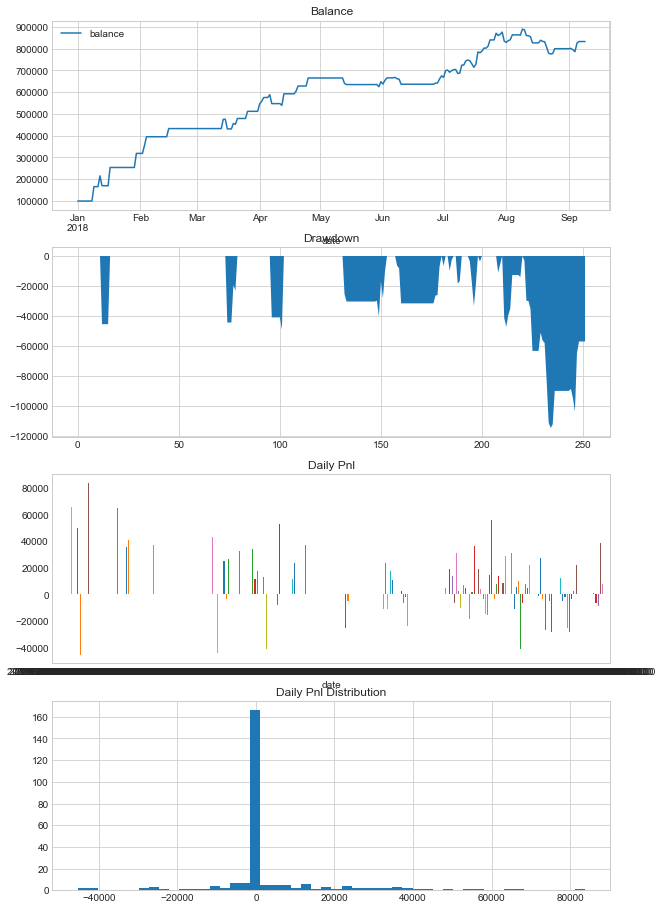

2018-09-10 17:45:23.462448	计算回测结果
单笔盈亏： 4.421939301393394 开仓： 2018-01-09 18:01:00 ,  14773.98 平仓: 2018-01-09 22:01:00 ,  14100.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.6486203049460704 开仓： 2018-01-12 06:01:00 ,  13445.0 平仓: 2018-01-12 07:01:00 ,  12935.62 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.4285650224215263 开仓： 2018-01-13 03:01:00 ,  13380.0 平仓: 2018-01-13 04:46:00 ,  13820.01 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.76186657045742 开仓： 2018-01-17 17:46:00 ,  10199.99 平仓: 2018-01-17 19:46:00 ,  9802.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.546838990765353 开仓： 2018-01-17 22:01:00 ,  9809.81 平仓: 2018-01-17 22:46:00 ,  9350.04 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.689126034534429 开仓： 2018-01-30 04:01:00 ,  11278.02 平仓: 2018-01-30 21:46:00 ,  10620.61 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.057851772039256 开仓： 2018-02-03 10:01:00 ,  8640.61 平仓: 2018-02-03 11:46:00 ,  8277.89 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.479331254182284 开仓： 2018-02-04 09:

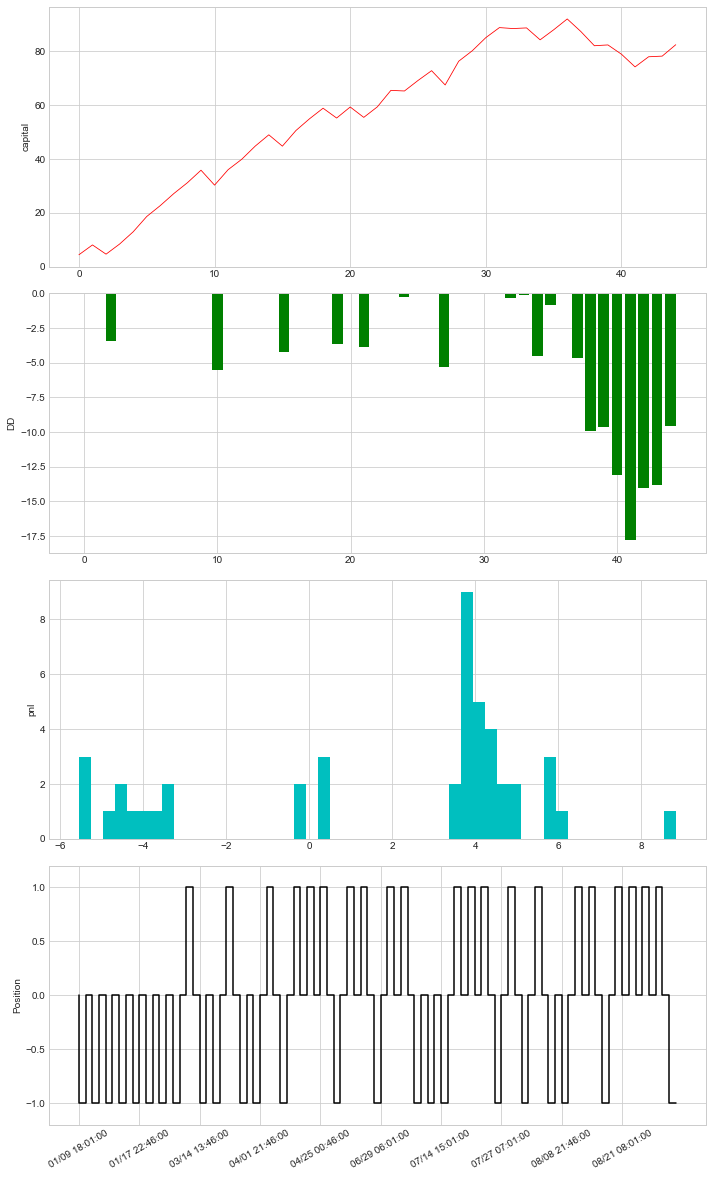

In [10]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [11]:
engine.calculateBacktestingResult()

2018-09-10 17:45:24.476020	计算回测结果
单笔盈亏： 4.421939301393394 开仓： 2018-01-09 18:01:00 ,  14773.98 平仓: 2018-01-09 22:01:00 ,  14100.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.6486203049460704 开仓： 2018-01-12 06:01:00 ,  13445.0 平仓: 2018-01-12 07:01:00 ,  12935.62 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.4285650224215263 开仓： 2018-01-13 03:01:00 ,  13380.0 平仓: 2018-01-13 04:46:00 ,  13820.01 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.76186657045742 开仓： 2018-01-17 17:46:00 ,  10199.99 平仓: 2018-01-17 19:46:00 ,  9802.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.546838990765353 开仓： 2018-01-17 22:01:00 ,  9809.81 平仓: 2018-01-17 22:46:00 ,  9350.04 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 5.689126034534429 开仓： 2018-01-30 04:01:00 ,  11278.02 平仓: 2018-01-30 21:46:00 ,  10620.61 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.057851772039256 开仓： 2018-02-03 10:01:00 ,  8640.61 平仓: 2018-02-03 11:46:00 ,  8277.89 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.479331254182284 开仓： 2018-02-04 09:

{'capital': 82.472087216725,
 'maxCapital': 92.04671516363432,
 'drawdown': -9.574627946909317,
 'totalResult': 45,
 'totalTurnover': 9000,
 'totalCommission': 4.5,
 'totalSlippage': 1.800000000000001,
 'timeList': [Timestamp('2018-01-09 22:01:00'),
  Timestamp('2018-01-12 07:01:00'),
  Timestamp('2018-01-13 04:46:00'),
  Timestamp('2018-01-17 19:46:00'),
  Timestamp('2018-01-17 22:46:00'),
  Timestamp('2018-01-30 21:46:00'),
  Timestamp('2018-02-03 11:46:00'),
  Timestamp('2018-02-04 20:01:00'),
  Timestamp('2018-02-15 11:01:00'),
  Timestamp('2018-03-14 18:46:00'),
  Timestamp('2018-03-16 21:46:00'),
  Timestamp('2018-03-21 00:46:00'),
  Timestamp('2018-03-26 22:46:00'),
  Timestamp('2018-04-01 21:46:00'),
  Timestamp('2018-04-03 12:01:00'),
  Timestamp('2018-04-07 23:46:00'),
  Timestamp('2018-04-13 16:01:00'),
  Timestamp('2018-04-20 18:46:00'),
  Timestamp('2018-04-25 10:46:00'),
  Timestamp('2018-05-14 00:46:00'),
  Timestamp('2018-06-03 14:46:00'),
  Timestamp('2018-06-10 08:46:

# BTC bitfinex数据

In [12]:
if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20170701 01:01',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180909 01:01')
#     engine.setStartDate('20180508 01:01',initDays=1)               # 设置回测用的数据起始日期
#     engine.setEndDate('20180710 01:01')
    
    # 配置回测引擎参数
    engine.setSlippage(0.0002)     # 设置滑点为股指1跳
    engine.setRate(5/10000)   # 设置手续费万0.3
    engine.setSize(100)     # 设置期货合约大小 100美金
    # engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(100000)  # 设置回测本金


    # # 在引擎中创建策略对象
    d = {'symbolList':['tBTCUSD:bitfinex']}          # 策略参数配置
    engine.initStrategy(FishStrategy, d)    # 创建策略对象
#     test = open('log.txt','w') 
    engine.runBacktesting()
#     test.close()

仓位字典构造完成 
初始仓位: {'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0} 
可平仓量: {'tBTCUSD:bitfinex_LONG': 0, 'tBTCUSD:bitfinex_SHORT': 0}
2018-09-10 17:45:24.729040	开始回测
2018-09-10 17:45:24.729040	策略初始化
2018-09-10 17:45:24.729538	载入历史数据。数据范围:[20170630 01:01,20170701 01:01)
2018-09-10 17:45:24.784434	载入完成，数据量：2
2018-09-10 17:45:24.784935	策略初始化完成
2018-09-10 17:45:24.784935	策略启动完成
2018-09-10 17:45:24.784935	开始回放回测数据,回测范围:[20170701 01:01,20180909 01:01)
2018-09-10 17:45:24.872267	载入历史数据。数据范围:[20170701 01:01,20180909 01:01)
2018-09-10 18:03:49.542649	载入完成，数据量：624077
2018-09-10 18:03:49.621500	当前回放数据:[20170701 01:01,20180909 01:01)
trade direction 多 offset 开仓 price 2559.0 2017-07-04 00:01:00
trade direction 空 offset 平仓 price 2502.3 2017-07-05 19:01:00
trade direction 空 offset 开仓 price 2502.3 2017-07-05 19:01:00
trade direction 多 offset 平仓 price 2589.5 2017-07-06 02:46:00
trade direction 空 offset 开仓 price 2513.8 2017-07-10 05:46:00
trade direction 多 offset 平仓 price 2403.7 2017-07-10 22:01:00

trade direction 多 offset 开仓 price 8116.0 2018-04-19 01:01:00
trade direction 空 offset 平仓 price 8502.2 2018-04-20 18:46:00
trade direction 多 offset 开仓 price 8935.1 2018-04-22 23:46:00
trade direction 空 offset 平仓 price 9274.1 2018-04-24 14:01:00
trade direction 多 offset 开仓 price 9310.0 2018-04-24 23:46:00
trade direction 空 offset 平仓 price 9727.7 2018-04-25 10:46:00
trade direction 空 offset 开仓 price 9643.9 2018-05-05 02:46:00
trade direction 多 offset 平仓 price 9932.0 2018-05-05 18:46:00
trade direction 空 offset 开仓 price 8384.6 2018-05-13 14:01:00
trade direction 多 offset 平仓 price 8638.0 2018-05-14 00:46:00
trade direction 空 offset 开仓 price 7201.8 2018-05-29 03:01:00
trade direction 多 offset 平仓 price 7423.7 2018-05-29 21:46:00
trade direction 多 offset 开仓 price 7423.2 2018-05-29 22:46:00
trade direction 空 offset 平仓 price 7740.1 2018-06-03 14:46:00
trade direction 空 offset 开仓 price 7487.41078126 2018-06-05 07:46:00
trade direction 多 offset 平仓 price 7647.4 2018-06-07 06:46:00
trade direction 多

2018-09-10 18:04:01.128353	计算按日统计结果
2018-09-10 18:04:01.182251	------------------------------
2018-09-10 18:04:01.182251	首个交易日：	2017-07-01 00:00:00
2018-09-10 18:04:01.182251	最后交易日：	2018-09-09 00:00:00
2018-09-10 18:04:01.182251	总交易日：	436
2018-09-10 18:04:01.182251	盈利交易日	93
2018-09-10 18:04:01.182750	亏损交易日：	80
2018-09-10 18:04:01.182750	起始资金：	100000
2018-09-10 18:04:01.182750	结束资金：	958,500.27
2018-09-10 18:04:01.182750	总收益率：	858.5%
2018-09-10 18:04:01.182750	年化收益：	472.57%
2018-09-10 18:04:01.182750	总盈亏：	858,500.27
2018-09-10 18:04:01.182750	最大回撤: 	-118,369.14
2018-09-10 18:04:01.182750	百分比最大回撤: -67.23%
2018-09-10 18:04:01.182750	总手续费：	73,099.43
2018-09-10 18:04:01.182750	总滑点：	4.28
2018-09-10 18:04:01.183249	总成交金额：	146,198,865.37
2018-09-10 18:04:01.183249	总成交笔数：	214
2018-09-10 18:04:01.183249	日均盈亏：	1,969.04
2018-09-10 18:04:01.183249	日均手续费：	167.66
2018-09-10 18:04:01.183249	日均滑点：	0.01
2018-09-10 18:04:01.183249	日均成交金额：	335,318.5
2018-09-10 18:04:01.183249	日均成交笔数：	0.49
2018-09-10 18:04:

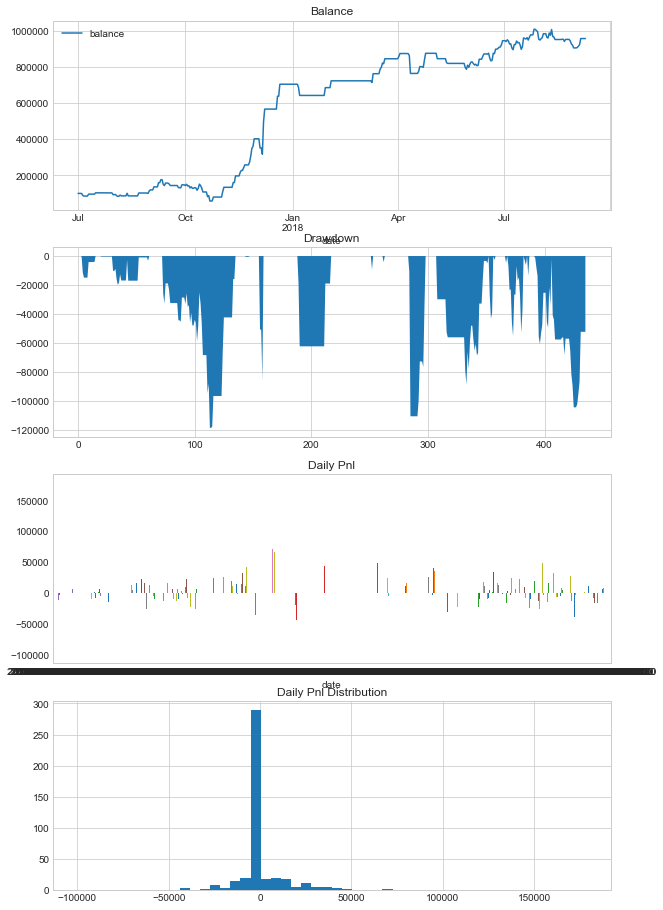

2018-09-10 18:04:05.717627	计算回测结果
单笔盈亏： -2.3557092614302393 开仓： 2017-07-04 00:01:00 ,  2559.0 平仓: 2017-07-05 19:01:00 ,  2502.3 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.6247939895296257 开仓： 2017-07-05 19:01:00 ,  2502.3 平仓: 2017-07-06 02:46:00 ,  2589.5 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.239823374970179 开仓： 2017-07-10 05:46:00 ,  2513.8 平仓: 2017-07-10 22:01:00 ,  2403.7 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.632724970881653 开仓： 2017-07-16 15:46:00 ,  1974.7 平仓: 2017-07-16 19:46:00 ,  1900.2 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.699694656488546 开仓： 2017-07-21 00:01:00 ,  2620.0 平仓: 2017-07-21 04:46:00 ,  2720.6 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.7985365853658535 开仓： 2017-07-21 17:01:00 ,  2706.0 平仓: 2017-07-21 21:01:00 ,  2805.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.70216176143524 开仓： 2017-07-31 13:01:00 ,  2697.8 平仓: 2017-07-31 20:46:00 ,  2793.9 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.521642512077305 开仓： 2017-08-02 09:46:00 ,  2711.7 

单笔盈亏： -3.1622073801970236 开仓： 2018-05-13 14:01:00 ,  8384.6 平仓: 2018-05-14 00:46:00 ,  8638.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.221174150906713 开仓： 2018-05-29 03:01:00 ,  7201.8 平仓: 2018-05-29 21:46:00 ,  7423.7 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.129048388835011 开仓： 2018-05-29 22:46:00 ,  7423.2 平仓: 2018-06-03 14:46:00 ,  7740.1 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -2.2767762957581006 开仓： 2018-06-05 07:46:00 ,  7487.41078126 平仓: 2018-06-07 06:46:00 ,  7647.4 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.37145121217668514 开仓： 2018-06-07 06:46:00 ,  7647.4 平仓: 2018-06-08 16:01:00 ,  7629.7 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.482724353513242 开仓： 2018-06-08 16:01:00 ,  7629.7 平仓: 2018-06-10 09:01:00 ,  7277.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.448614852983905 开仓： 2018-06-13 16:01:00 ,  6540.1 平仓: 2018-06-14 00:46:00 ,  6240.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.6116459197786948 开仓： 2018-06-17 20:01:00 ,  6507.0 平仓: 2018-06-19 01:46:00 

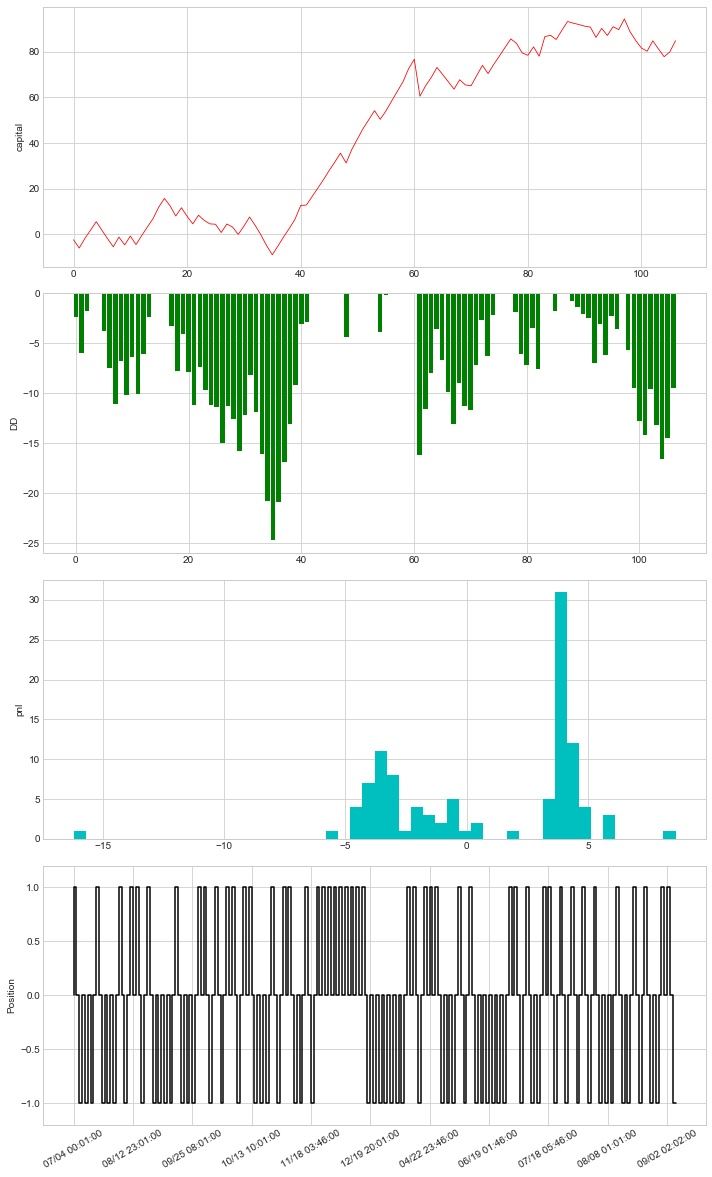

In [13]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [14]:
engine.calculateBacktestingResult()

2018-09-10 18:04:06.929323	计算回测结果
单笔盈亏： -2.3557092614302393 开仓： 2017-07-04 00:01:00 ,  2559.0 平仓: 2017-07-05 19:01:00 ,  2502.3 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.6247939895296257 开仓： 2017-07-05 19:01:00 ,  2502.3 平仓: 2017-07-06 02:46:00 ,  2589.5 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.239823374970179 开仓： 2017-07-10 05:46:00 ,  2513.8 平仓: 2017-07-10 22:01:00 ,  2403.7 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.632724970881653 开仓： 2017-07-16 15:46:00 ,  1974.7 平仓: 2017-07-16 19:46:00 ,  1900.2 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.699694656488546 开仓： 2017-07-21 00:01:00 ,  2620.0 平仓: 2017-07-21 04:46:00 ,  2720.6 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.7985365853658535 开仓： 2017-07-21 17:01:00 ,  2706.0 平仓: 2017-07-21 21:01:00 ,  2805.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.70216176143524 开仓： 2017-07-31 13:01:00 ,  2697.8 平仓: 2017-07-31 20:46:00 ,  2793.9 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.521642512077305 开仓： 2017-08-02 09:46:00 ,  2711.7 

单笔盈亏： -2.2767762957581006 开仓： 2018-06-05 07:46:00 ,  7487.41078126 平仓: 2018-06-07 06:46:00 ,  7647.4 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -0.37145121217668514 开仓： 2018-06-07 06:46:00 ,  7647.4 平仓: 2018-06-08 16:01:00 ,  7629.7 交易数量： 1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.482724353513242 开仓： 2018-06-08 16:01:00 ,  7629.7 平仓: 2018-06-10 09:01:00 ,  7277.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.448614852983905 开仓： 2018-06-13 16:01:00 ,  6540.1 平仓: 2018-06-14 00:46:00 ,  6240.0 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： -3.6116459197786948 开仓： 2018-06-17 20:01:00 ,  6507.0 平仓: 2018-06-19 01:46:00 ,  6732.9 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 4.08014456078675 开仓： 2018-06-20 13:01:00 ,  6599.3 平仓: 2018-06-22 18:01:00 ,  6320.8 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.629390376445024 开仓： 2018-06-23 15:46:00 ,  6072.6 平仓: 2018-06-24 14:46:00 ,  5843.7 交易数量： -1 合约面值： 100 滑点： 0.04 手续费： 0.1
单笔盈亏： 3.8294656488549617 开仓： 2018-06-26 15:46:00 ,  6222.5 平仓: 2018-06-29 05:46:00 , 

{'capital': 84.86454074878722,
 'maxCapital': 94.37327869951987,
 'drawdown': -9.508737950732652,
 'totalResult': 107,
 'totalTurnover': 21400,
 'totalCommission': 10.699999999999978,
 'totalSlippage': 4.280000000000003,
 'timeList': [Timestamp('2017-07-05 19:01:00'),
  Timestamp('2017-07-06 02:46:00'),
  Timestamp('2017-07-10 22:01:00'),
  Timestamp('2017-07-16 19:46:00'),
  Timestamp('2017-07-21 04:46:00'),
  Timestamp('2017-07-21 21:01:00'),
  Timestamp('2017-07-31 20:46:00'),
  Timestamp('2017-08-04 04:01:00'),
  Timestamp('2017-08-06 01:46:00'),
  Timestamp('2017-08-07 00:46:00'),
  Timestamp('2017-08-12 23:01:00'),
  Timestamp('2017-08-13 04:46:00'),
  Timestamp('2017-08-22 09:46:00'),
  Timestamp('2017-09-01 09:46:00'),
  Timestamp('2017-09-04 17:01:00'),
  Timestamp('2017-09-08 22:46:00'),
  Timestamp('2017-09-10 13:46:00'),
  Timestamp('2017-09-12 13:46:00'),
  Timestamp('2017-09-13 02:01:00'),
  Timestamp('2017-09-14 19:46:00'),
  Timestamp('2017-09-18 01:46:00'),
  Timestamp